# First-Year Colloquium

This notebook contains the figures I will add to my first year colloquium slides. I'd like to have profiles (one smooth and one with lots of layers) to show compensating T-S variation, and some maps of the tracer variance production rate metric.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
from xhistogram.xarray import histogram
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
from flox.xarray import xarray_reduce

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [46]:
import matplotlib
print(matplotlib.rcParams['font.family'])


['sans-serif']


In [26]:
import matplotlib.pyplot as plt

# Function to scale all font sizes by a percentage
def scale_font_sizes(scale_percent):
    for param in ['font.size', 'axes.titlesize', 'axes.labelsize',
                  'xtick.labelsize', 'ytick.labelsize', 'legend.fontsize']:
        current_value = plt.rcParams[param]
        if isinstance(current_value, (int, float)):  # Check if the value is numeric
            plt.rcParams[param] *= (1 + scale_percent / 100)

# Example: Increase all font sizes by 25%
scale_font_sizes(35)

## Profiles

In [27]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})

In [28]:
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))
ds

<xarray.Dataset> Size: 123GB
Dimensions:            (PRES_INTERPOLATED: 1001, N_PROF: 2550896)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
    TIME               (N_PROF) datetime64[ns] 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LATITUDE           (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LONGITUDE          (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
  * N_PROF             (N_PROF) int64 20MB 0 1 2 3 ... 2550893 2550894 2550895
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    CYCLE_NUMBER       (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DATA_MODE          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DIRECTION          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PLATFORM_NUMBER    (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PRES               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SA                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [29]:
sample_max = 2.5

ds = ds.sortby('LATITUDE').persist()
boolean_indexer = (ds.sample_rate < sample_max).compute()
ds = ds.where(boolean_indexer, drop=True)

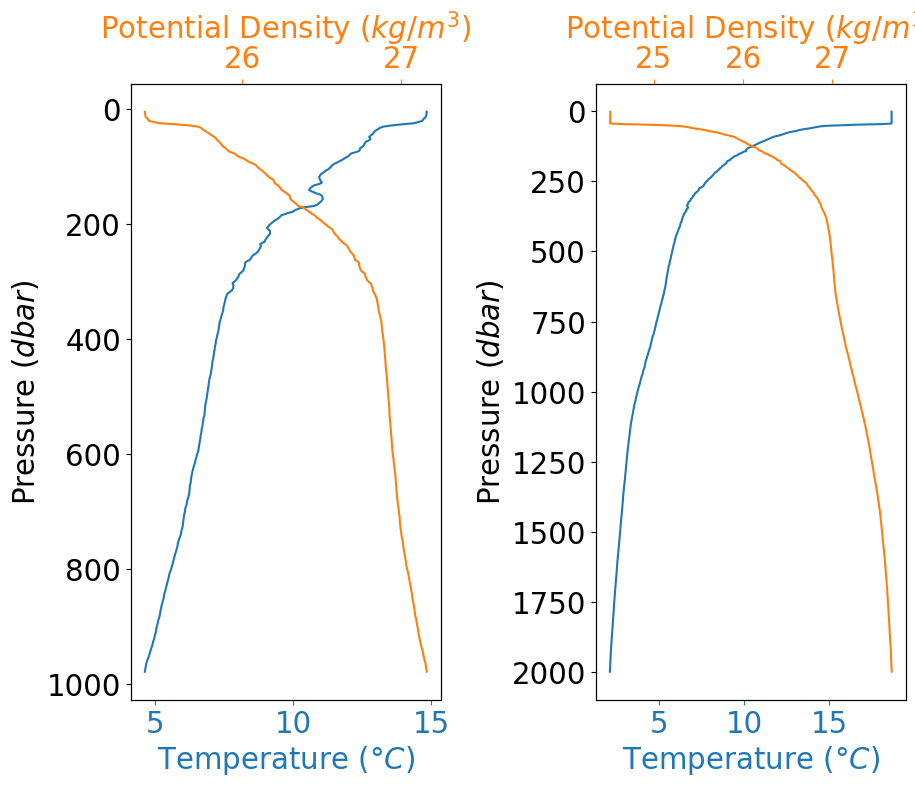

In [30]:
prof1 = 300090
prof2 = 300100

fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(10, 8))

ds.CT.isel(N_PROF=prof1).plot(ax=ax1, y='PRES_INTERPOLATED')
ax1.set_xlabel('Temperature ($°C$)', color='tab:blue')
ax1.set_ylabel('Pressure ($dbar$)')
ax1.tick_params(axis='x', colors='tab:blue')
ax1.invert_yaxis()  # Invert the y-axis
ax2 = ax1.twiny()
ds.SIG0.isel(N_PROF=prof1).plot(ax=ax2, y='PRES_INTERPOLATED', color='tab:orange')
ax2.set_xlabel('Potential Density ($kg/m^3$)', color='tab:orange')
ax2.tick_params(axis='x', colors='tab:orange')
ax1.set_title('')
ax2.set_title('')

ds.CT.isel(N_PROF=prof2).plot(ax=ax3, y='PRES_INTERPOLATED')
ax3.set_xlabel('Temperature ($°C$)', color='tab:blue')
ax3.set_ylabel('Pressure ($dbar$)')
ax3.tick_params(axis='x', colors='tab:blue')
ax3.invert_yaxis()  # Invert the y-axis
ax4 = ax3.twiny()
ds.SIG0.isel(N_PROF=prof2).plot(ax=ax4, y='PRES_INTERPOLATED', color='tab:orange')
ax4.set_xlabel('Potential Density ($kg/m^3$)', color='tab:orange')
ax4.tick_params(axis='x', colors='tab:orange')
ax3.set_title('')
ax4.set_title('')

plt.subplots_adjust(wspace=0.5)

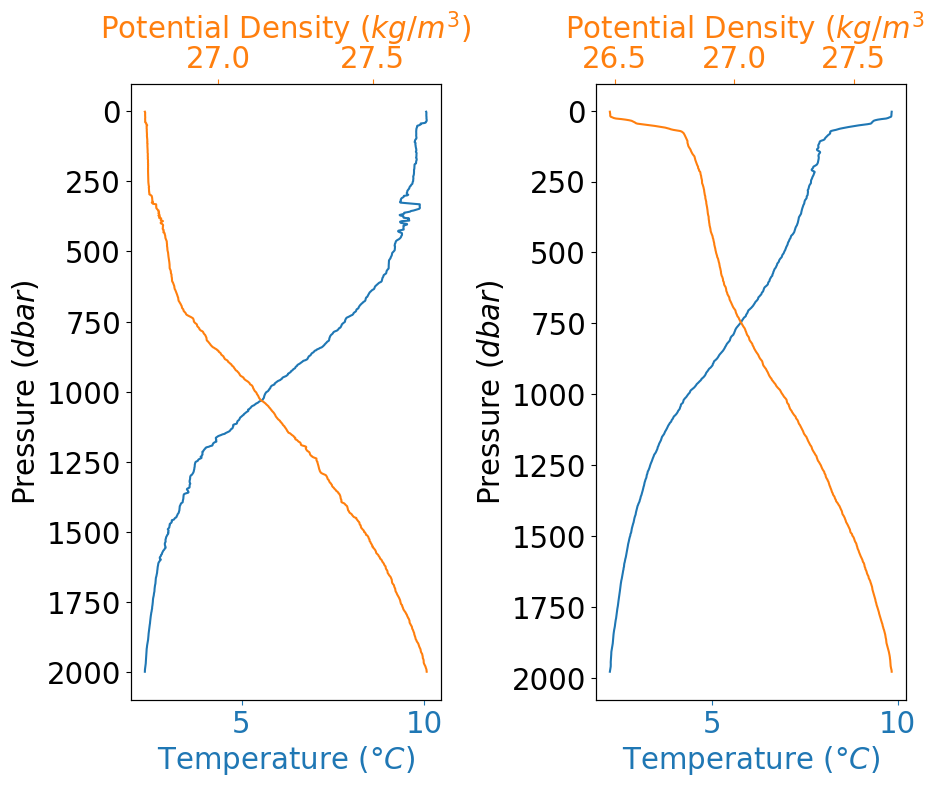

In [31]:
prof1 = 200300
prof2 = 200292

fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(10, 8))

ds.CT.isel(N_PROF=prof1).plot(ax=ax1, y='PRES_INTERPOLATED')
ax1.set_xlabel('Temperature ($°C$)', color='tab:blue')
ax1.set_ylabel('Pressure ($dbar$)')
ax1.tick_params(axis='x', colors='tab:blue')
ax1.invert_yaxis()  # Invert the y-axis
ax2 = ax1.twiny()
ds.SIG0.isel(N_PROF=prof1).plot(ax=ax2, y='PRES_INTERPOLATED', color='tab:orange')
ax2.set_xlabel('Potential Density ($kg/m^3$)', color='tab:orange')
ax2.tick_params(axis='x', colors='tab:orange')
ax1.set_title('')
ax2.set_title('')

ds.CT.isel(N_PROF=prof2).plot(ax=ax3, y='PRES_INTERPOLATED')
ax3.set_xlabel('Temperature ($°C$)', color='tab:blue')
ax3.set_ylabel('Pressure ($dbar$)')
ax3.tick_params(axis='x', colors='tab:blue')
ax3.invert_yaxis()  # Invert the y-axis
ax4 = ax3.twiny()
ds.SIG0.isel(N_PROF=prof2).plot(ax=ax4, y='PRES_INTERPOLATED', color='tab:orange')
ax4.set_xlabel('Potential Density ($kg/m^3$)', color='tab:orange')
ax4.tick_params(axis='x', colors='tab:orange')
ax3.set_title('')
ax4.set_title('')

plt.subplots_adjust(wspace=0.5)

## Lots of calculation

In [32]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,90,3)

In [33]:
def get_ds_binned(ds, lon_bins, lat_bins):
    
    ds_binned = xarray_reduce(
    ds,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)
    
    lon_l = np.arange(lon_bins[0],lon_bins[-1],3)
    lon_r = np.arange(lon_bins[1],lon_bins[-1]+1,3)
    lon_c = (lon_l + lon_r)/2

    lat_l = np.arange(lat_bins[0],lat_bins[-1],3)
    lat_r = np.arange(lat_bins[1],lat_bins[-1]+1,3)
    lat_c = (lat_l + lat_r)/2

    ds_binned = ds_binned.assign_coords({
        "lat_c": ("LATITUDE_bins", lat_c),
        "lat_l": ("LATITUDE_bins", lat_l),
        "lat_r": ("LATITUDE_bins", lat_r),
        "lon_c": ("LONGITUDE_bins", lon_c),
        "lon_l": ("LONGITUDE_bins", lon_l),
        "lon_r": ("LONGITUDE_bins", lon_r),
    })
    
    ds_binned = ds_binned.swap_dims({"LATITUDE_bins": "lat_c", "LONGITUDE_bins": "lon_c"})
    ds_binned = ds_binned.drop_vars(["LATITUDE_bins", "LONGITUDE_bins"])
    
    if isinstance(ds_binned, xr.Dataset):
        # For xarray.Dataset, use rename_dims and rename_vars
        ds_binned = ds_binned.rename_dims({"PRES_INTERPOLATED": "z_c"}).rename_vars({"PRES_INTERPOLATED": "z_c"})
    elif isinstance(ds_binned, xr.DataArray):
        # For xarray.DataArray, use rename to rename the dimension
        ds_binned = ds_binned.rename({"PRES_INTERPOLATED": "z_c"})
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    
    return ds_binned

In [39]:
lfilt = 100

In [35]:
ds_clip = ds.where(ds.LATITUDE>-67.5, drop=True).where(ds.LATITUDE<67.5, drop=True)

In [36]:
ds_binned = get_ds_binned(ds, lon_bins, lat_bins)
ds_clip_binned = get_ds_binned(ds_clip, lon_bins, lat_bins)

In [37]:
ds_diff = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc')
K_rho = ds_diff.K
K_rho = K_rho.interp_like(ds_clip_binned)

In [42]:
ct_b = ds_clip.CT
sa_b = ds_clip.SA
sp_b = ds_clip.SPICE

ct_m = ff.ds_filt_single(ds_clip, lfilt, 'CT')
sa_m = ff.ds_filt_single(ds_clip, lfilt, 'SA')
sp_m = ff.ds_filt_single(ds_clip, lfilt, 'SPICE')

ct_e = ct_b - ct_m
sa_e = sa_b - sa_m
sp_e = sp_b - sp_m

MemoryError: Unable to allocate 10.9 GiB for an array with shape (1454958, 1001) and data type float64

In [ ]:
ct_2 = K_rho*get_ds_binned(ff.da_filt_single((ct_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt), lon_bins, lat_bins)
sa_2 = K_rho*get_ds_binned(ff.da_filt_single((sa_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt), lon_bins, lat_bins)
sp_2 = K_rho*get_ds_binned(ff.da_filt_single((sp_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt), lon_bins, lat_bins)

ct_3 = K_rho*get_ds_binned((ct_m.differentiate(coord='PRES_INTERPOLATED'))**2, lon_bins, lat_bins)
sa_3 = K_rho*get_ds_binned((sa_m.differentiate(coord='PRES_INTERPOLATED'))**2, lon_bins, lat_bins)
sp_3 = K_rho*get_ds_binned((sp_m.differentiate(coord='PRES_INTERPOLATED'))**2, lon_bins, lat_bins)

In [ ]:
ct_tot  = ct_2 + ct_3
ct_2rat = ct_2/ct_tot
ct_3rat = ct_3/ct_tot

sa_tot  = sa_2 + sa_3
sa_2rat = sa_2/sa_tot
sa_3rat = sa_3/sa_tot

sp_tot  = sp_2 + sp_3
sp_2rat = sp_2/sp_tot
sp_3rat = sp_3/sp_tot

## Variance maps!

In [ ]:
depth = 500
lon = -25
lat = -55

In [ ]:
start = 10**-12
end   = 10**-8
norm  = colors.LogNorm(vmin=start, vmax=end)
cmap  = cmo.matter_r

In [ ]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ct_2.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax1, norm = norm, cmap=cmap)
ax1.set_title(f'Mesoscale Temperature Variance Production Rate binned @{depth}m')

In [ ]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ct_3.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax1, norm = norm, cmap=cmap)
ax1.set_title(f'Microscale Temperature Variance Production Rate binned @{depth}m')

In [ ]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ct_2rat.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax1, cmap=cmo.balance)
ax1.set_title(f'Mesoscale Fraction of the Variance Production Rate @{depth}m')